### Wikiart: Conditional Generative Adverserial Network (cGAN)

### Load Libraries

In [ ]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils import data
from torch.utils.data import DataLoader
from google.colab import drive
import argparse
import os
from os import walk
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time
import sys
import tensorflow as tf
from torch.autograd import Variable


### Mount Google Drive

In [ ]:
# mount drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load Metric Modules

In [ ]:
# load inception score metric
inception_path = '/content/drive/MyDrive/neural_networks/modules/inception_score_pytorch'
#!cat '/content/drive/MyDrive/neural_networks/modules/inception_score_pytorch/inception_score.py'
sys.path.append(inception_path)
from inception_score import inception_score
frechet_path = '/content/drive/MyDrive/neural_networks/modules/frechet_inception_distance'
#!cat '/content/drive/MyDrive/neural_networks/modules/frechet_inception_distance/frechet_inception_distance.py'
sys.path.append(frechet_path)
from frechet_inception_distance import frechet_id

### Training Parameters

In [ ]:
num_epochs = 200
batch_size = 64
learning_rate = 1e-4
use_gpu = True
ngpu = 1
img_size = 64
# device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
tolerance = 1e-6
# use smaller wiki art data for testing
use_test_data = False
# number of data loader workers
n_workers = 8

### Load Subset Wikiart Data

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


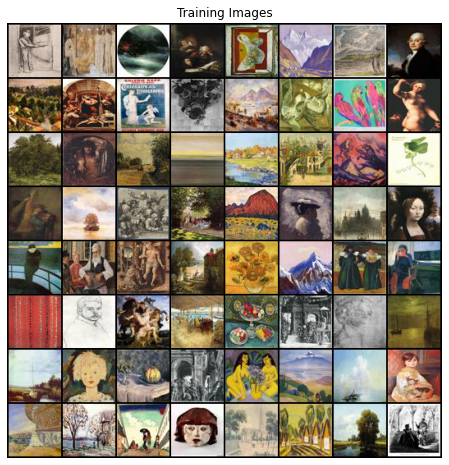

In [ ]:
# print subfolders/art styles of the wikiart subset directory
#!ls '/content/drive/MyDrive/neural_networks/data/wikiart_resized'
# set parent folder of wikiart as file directory
if use_test_data == True:
    data_dir = '/content/drive/MyDrive/neural_networks/data/wikiart_subset'

elif use_test_data == False:
    data_dir = '/content/drive/MyDrive/neural_networks/data/wikiart_resized'

# set random seed
random.seed(1486438)
torch.manual_seed(1486438)

# define transformer for data loader
# resize and normalize data for slight performance boost
img_transform = transforms.Compose([
                                    transforms.Resize((img_size, img_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), 
                                                         (0.5, 0.5, 0.5))
                                  ])

dataset = datasets.ImageFolder(root = data_dir,
                           transform = img_transform)
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers = n_workers)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), padding=2, 
                                         normalize=True).cpu(),(1,2,0)))

### Custom Weight Initialization

In [ ]:
# custom weights initialization called on netG and netD
# set random seed
random.seed(1486438)
torch.manual_seed(1486438)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def gaussian(ins, mean, stddev):
    noise = Variable(ins.data.new(ins.size()).normal_(mean, stddev))
    return ins + noise

### Gan Parameters

In [ ]:
# number of channels (1 = gray, 3 = RGB colors)
nc = 3
# number/size of latent vector z for the generator input
nz = 150
# size/number of feature maps in generator
ngf = 64
# size/number of feature maps in discriminator
ndf = 64
# ndf = 32

# number of art style classes
if use_test_data == True:
  # test wikiart has 5 art style
  n_class = 5
elif use_test_data == False:
  # complete data has 27 art styles
  n_class = 27

# number of examples to be generated
example_size = 8

# define fixed noise to sample images from the latent space of the generator
fixed_noise = torch.randn(n_class*example_size, nz, 1, 1, device=device)

fixed_label = torch.tensor(list(np.repeat([i for i in range(n_class)], 
                                          example_size))).type(torch.LongTensor).to(device)

# establish convention for real and fake labels 
real_label = 1.
fake_label = 0.

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu=1):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(n_class, n_class)
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz + n_class, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
    def forward(self, noise_input, labels):
        # Concatenate label embedding and image to produce input
        #print(self.label_emb(labels).unsqueeze(2).unsqueeze(3).shape, noise_input.shape, labels.shape)
        gen_input = torch.cat((self.label_emb(labels).unsqueeze(2).unsqueeze(3), noise_input), 1)
        img = self.main(gen_input)
        img = img.view(img.size(0), *(nc, img_size, img_size))
        return img

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, ngpu=1):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(n_class, ndf*16*4)
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 2 x 2
            nn.Flatten()
        )
        self.linear = nn.Sequential(
        nn.Linear(ndf*16*4*2, ndf*16),    
        nn.LeakyReLU(0.2, inplace=True),   
        nn.Linear(ndf*16, 1),
        nn.Sigmoid()    
        )

    def forward(self, input, labels):
        disc_out = self.main(input)
        #print(input.shape, labels.shape, self.label_emb(labels).shape, disc_out.shape)
        linear_input = torch.cat((self.label_emb(labels), disc_out), 1)
        linear_output = self.linear(linear_input.squeeze())
        #print(input.shape, labels.shape, disc_out.shape, linear_input.shape, linear_output.shape)
        return linear_output.unsqueeze(2).unsqueeze(3)
    
generator = Generator()
discriminator = Discriminator()

# apply the weights_init function to randomly initialize all weights
# to mean=0, stdev=0.02
generator.apply(weights_init)
discriminator.apply(weights_init)

# device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))
print('Generator Architecture:', generator)
print('Discriminator Architecture:', discriminator)

Number of parameters for generator: 4208217 and discriminator: 19649281
Generator Architecture: Generator(
  (label_emb): Embedding(27, 27)
  (main): Sequential(
    (0): ConvTranspose2d(177, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inpl

### Define Storage Location

In [ ]:
# mount google drive for saving checkpoints
drive.mount('/content/drive')

# checkpoint generator file name
gen_save_name = 'wikiart_c_gen.cpt'
# define location to store checkpoints for generator
path_gen = F'/content/drive/MyDrive/neural_networks/checkpoints/{gen_save_name}'

# checkpoint discriminator file name
disc_save_name = 'wikiart_c_disc.cpt'
# define location to store checkpoints for discriminator
path_disc = F'/content/drive/MyDrive/neural_networks/checkpoints/{disc_save_name}'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Train GAN

In [9]:
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate,
                                 betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate,
                                  betas=(0.5, 0.999))


# loss per iteration
gen_iter_loss = []
disc_iter_loss = []
#loss per epoch
gen_loss_avg = []
disc_loss_avg = []

gen_loss_avg.append(0)
disc_loss_avg.append(0)

iters = 0

# store generated images 
img_lst = []
# store generated images for gif
img_lst_gif = []

print(" Training...")
# For each epoch
for epoch in range(num_epochs):

    # start couting run time
    start_time = time.time() 
    
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0

    # for each batch in the data loader
    for i, (data, real_style_labels) in enumerate(dataloader, 0):

        # (1) Update discriminator network: maximize log(D(x)) + log(1 - D(G(z)))
        # disable gradients to save computation cost
        discriminator.zero_grad()
        # pass data to local device cpu
        real_cpu = data.to(device)
        # obtain batch size
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # pass style labels to device
        real_style_labels = real_style_labels.to(device)
        # fake labels are a random choice of style
        fake_style_labels = torch.tensor(np.random.choice(n_class, size = b_size)).type(torch.LongTensor).to(device)

        # pass batch to discriminator 
        output = discriminator(gaussian(real_cpu, mean=0, stddev=0.5*0.01**(epoch/num_epochs)), real_style_labels).view(-1)
        # compute disc loss
        disc_loss_real = F.binary_cross_entropy(output, label)
        # Calculate gradients for D in backward pass
        disc_loss_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake_image_batch = generator(noise, fake_style_labels)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = discriminator(fake_image_batch.detach(), fake_style_labels).view(-1)
        # Calculate D's loss on the all-fake batch
        disc_loss_fake = F.binary_cross_entropy(output, label)
        # Calculate the gradients for this batch
        disc_loss_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        disc_loss = 0.5 * (disc_loss_real + disc_loss_fake)
        # Update D
        disc_optimizer.step()

        # (2) Update generator network: maximize log(D(G(z)))
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake_image_batch, fake_style_labels).view(-1)
        # Calculate G's loss based on this output
        gen_loss = F.binary_cross_entropy(output, label)
        # Calculate gradients for G
        gen_loss.backward()
        D_G_z2 = output.mean().item()
        # Update G
        gen_optimizer.step()

        # average loss per iteration to obtain average loss per epoch
        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()

        # average loss per iteration to obtain average loss per epoch
        gen_iter_loss.append(gen_loss.item())
        disc_iter_loss.append(disc_loss.item())
        num_batches += 1

        # Output training stats
        if num_batches % 255 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     disc_loss.item(), gen_loss.item(), D_x, D_G_z1, D_G_z2))

        # Check how the generator is doing by saving G's output on fixed_noise
        #if (iters % 2000 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
        #if (i == len(dataloader)-1):
        #    with torch.no_grad():
        #        fake_img = generator(fixed_noise, fixed_label).detach().cpu()
        #    img_lst.append(vutils.make_grid(fake_img, nrow = example_size,padding=2, normalize=True))

        # Save generated image if: 
        # 1) at the first iteration
        # 2) final epoch has been reached
        # 3) a full batch of training passed i.e one epoch has passed
        elif (iters == 1) or (epoch == num_epochs) or (iters % len(dataloader) == 0):
            with torch.no_grad():
                fake = generator(fixed_noise, fixed_label).detach().cpu()
            # store image
            img_lst.append(fake)
            # store image for gif
            img_lst_gif.append(vutils.make_grid(fake, padding=2, normalize=True))
            print('No. of sample images stored: [%d]' % len(img_lst))
        iters += 1
    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches

 Training...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


No. of sample images stored: [1]
No. of sample images stored: [2]
[0/200][254/1273]	Loss_D: 0.3040	Loss_G: 4.0453	D(x): 0.8168	D(G(z)): 0.2118 / 0.0388
[0/200][509/1273]	Loss_D: 0.2556	Loss_G: 4.5985	D(x): 0.7845	D(G(z)): 0.1696 / 0.0213
[0/200][764/1273]	Loss_D: 0.2073	Loss_G: 4.5346	D(x): 0.7975	D(G(z)): 0.1079 / 0.0254
[0/200][1019/1273]	Loss_D: 0.3776	Loss_G: 4.3672	D(x): 0.7240	D(G(z)): 0.2051 / 0.0373
No. of sample images stored: [3]
[1/200][254/1273]	Loss_D: 0.3755	Loss_G: 3.5714	D(x): 0.6613	D(G(z)): 0.1591 / 0.0493
[1/200][509/1273]	Loss_D: 0.3904	Loss_G: 6.1248	D(x): 0.8878	D(G(z)): 0.3691 / 0.0047
[1/200][764/1273]	Loss_D: 0.3848	Loss_G: 4.1329	D(x): 0.6247	D(G(z)): 0.0890 / 0.0373
[1/200][1019/1273]	Loss_D: 0.3434	Loss_G: 3.2161	D(x): 0.6996	D(G(z)): 0.1467 / 0.0755
No. of sample images stored: [4]
[2/200][254/1273]	Loss_D: 0.3683	Loss_G: 3.4570	D(x): 0.8330	D(G(z)): 0.3014 / 0.0549
[2/200][509/1273]	Loss_D: 0.4718	Loss_G: 3.9650	D(x): 0.6674	D(G(z)): 0.2667 / 0.0409
[2/200

### Load Checkpoints

In [ ]:
# load models
disc_save_name = 'wikiart_dc_gen.cpt'
gen_save_name = 'wikiart_dc_disc.cpt'

path_gen = F'/content/drive/MyDrive/neural_networks/checkpoints/{gen_save_name}'
path_disc = F'/content/drive/MyDrive/neural_networks/checkpoints/{disc_save_name}'

# check whether checkpoint files exist
if os.path.isfile(path_gen) and os.path.isfile(path_disc) == True:
    checkpoint_gen = torch.load(path_gen)
    checkpoint_disc = torch.load(path_disc)

    # neural net is saved on the gpu we send it to the cpu via .to(device)
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    # given the kernel shut done and all variables are lost
    # optimizers need to be initialised again
    gen_optimizer = torch.optim.Adam(params=generator.parameters(), 
                                     lr=learning_rate, betas=(0.5, 0.999))
    disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), 
                                      lr=learning_rate, betas=(0.5, 0.999))
    generator.load_state_dict(checkpoint_gen['gen_state_dict'])
    discriminator.load_state_dict(checkpoint_disc['disc_state_dict'])
    gen_optimizer.load_state_dict(checkpoint_gen['optimizer_state_dict'])
    disc_optimizer.load_state_dict(checkpoint_disc['optimizer_state_dict'])
    epoch = checkpoint_gen['epoch']
    img_lst = checkpoint_gen['img_lst']
    img_lst_gif = checkpoint_gen['img_lst_gif']
    gen_loss_avg = checkpoint_gen['gen_loss_avg']
    disc_loss_avg = checkpoint_disc['disc_loss_avg']
else: 
    print("Checkpoint files not found or do not exist.")
    print("The neural network may have not been trained yet.")
#model_gen.eval()
# - or -
#model_gen.train()

KeyError: ignored

### Figures: First and Last Image

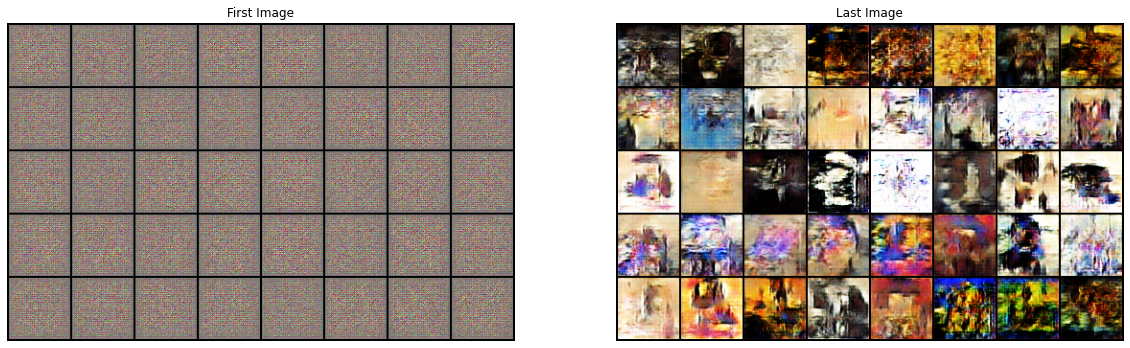

In [ ]:
# plot 1st image
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("First Image")
plt.imshow(np.transpose(vutils.make_grid(img_lst[0].to(device), padding=2, normalize=True).cpu(),(1,2,0)))
# plot last image
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Last Image")
plt.imshow(np.transpose(vutils.make_grid(img_lst[-1].to(device), padding=2, normalize=True).cpu(),(1,2,0)))

### Plot: Real Images vs Generated Images

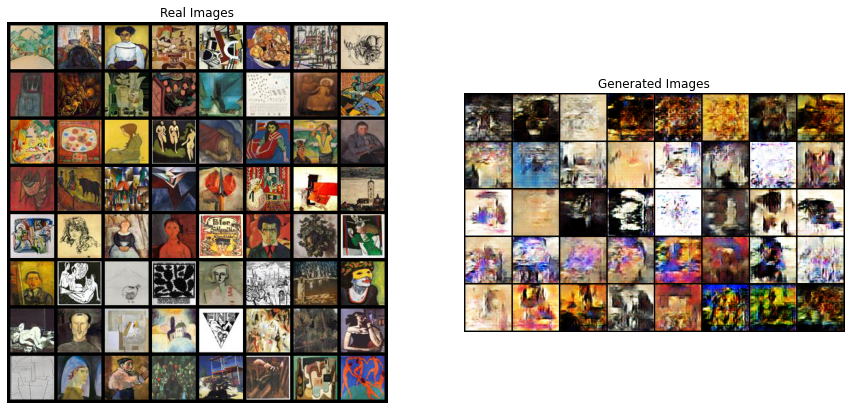

In [ ]:
# Grab a batch of real images from the dataloader
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, 
                                         normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(img_lst_gif[-1].cpu().numpy(),(1,2,0)))
plt.show()

### Gif: Image Generation Process

In [ ]:
# gif from starting image to last generated image
#%%capture
# if bytes for gif are too big increase limit 
plt.rcParams['animation.embed_limit'] = 2**128
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i.cpu().numpy(),(1,2,0)), animated=True)] for i in img_lst_gif]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

### Training Curves

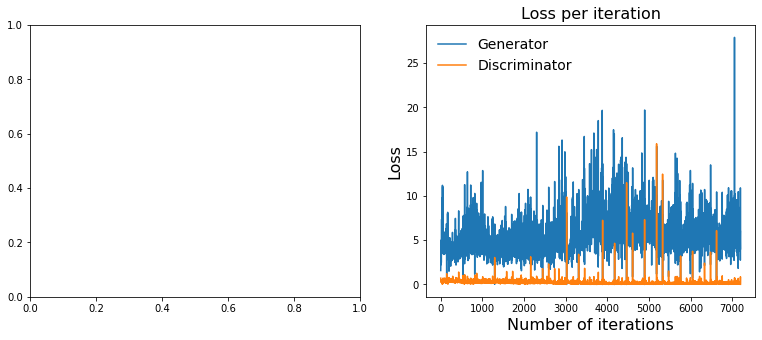

In [ ]:
# Plot average loss per epoch
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
#plt.plot(gen_loss_avg, linewidth=1.5)
#plt.plot(disc_loss_avg, linewidth=1.5)
#plt.title('Average loss per epoch', fontsize = 16)
#plt.xlabel('Number of epochs', fontsize = 16)
#plt.ylabel('Mean Loss', fontsize = 16)
#plt.legend(['Generator', 'Discriminator'], 
#           prop={'size': 14},           
#            frameon=False)

# Plot loss per iteration
plt.subplot(1,2,2)
plt.plot(gen_iter_loss, linewidth=1.5)
plt.plot(disc_iter_loss, linewidth=1.5)
plt.title('Loss per iteration', fontsize = 16)
plt.xlabel('Number of iterations', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)
plt.legend(['Generator', 'Discriminator'], 
           prop={'size': 14},           
            frameon=False)
plt.show()

### Image Evaluation Metrics

Inception score

In [10]:
stedv, means = [], []
imgs = []
for j in range(len(img_lst)):
  for i in range(len(img_lst[j])):
    imgs.append((vutils.make_grid(img_lst[j][i].to(device), padding=2, normalize=True).cpu()))
  if (j % 20 == 0): 
    print('Image metric computed for [%d / %d]' % (j, len(img_lst)))
  mean, stdv = inception_score(imgs, cuda=True, batch_size=32, resize=True, splits=10)
  means.append(mean)
  stedv.append(stdv)

Image metric computed for [0 / 201]


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/content/drive/MyDrive/neural_networks/modules/inception_score_pytorch/inception_score.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).d

Image metric computed for [20 / 201]
Image metric computed for [40 / 201]
Image metric computed for [60 / 201]
Image metric computed for [80 / 201]
Image metric computed for [100 / 201]
Image metric computed for [120 / 201]
Image metric computed for [140 / 201]
Image metric computed for [160 / 201]
Image metric computed for [180 / 201]
Image metric computed for [200 / 201]


Frechet Inception Distance

In [ ]:
real_batch = next(iter(dataloader))
fids = []
for i in range(len(img_lst)):
  fids.append(frechet_id(img_lst[i], real_batch))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
# Plot average loss per epoch
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(means, linewidth=1.5)
plt.title('Inception score per epoch', fontsize = 16)
plt.xlabel('Number of epochs', fontsize = 16)
plt.ylabel('Inception score', fontsize = 16)
plt.legend(['IS'], 
           prop={'size': 14},           
            frameon=False)

# Plot loss per iteration
plt.subplot(1,2,2)
plt.plot(fids, linewidth=1.5)
plt.title('Frechet inception distance per epoch', fontsize = 16)
plt.xlabel('Number of epochs', fontsize = 16)
plt.ylabel('Frechet inception distance', fontsize = 16)
plt.legend(['FID'], 
           prop={'size': 14},           
            frameon=False)
plt.show()

### Store Metrics in txt file

In [ ]:
with open('/content/drive/MyDrive/neural_networks/metric_results/c_gan_is_means.txt','w') as values:
   values.write(str(means))

with open('/content/drive/MyDrive/neural_networks/metric_results/c_gan_fid_means.txt','w') as values:
   values.write(str(fids))

NEvAr Metric

In [ ]:
import tensorflow as tf
# convert pytorch tensor to np array
tensor_to_np = img_lst[110].detach().cpu().numpy()
# convert np array to tf tensor
tf_tensor = tf.convert_to_tensor(tensor_to_np)
# set it as image
img = tf_tensor
# perform tf sobel edge operation
grad_components = tf.image.sobel_edges(img)
# compute gradient magnitute 
grad_mag_components = grad_components**2
# sum magnitude components
grad_mag_square = tf.math.reduce_sum(grad_mag_components,axis=-1)
# sobel edge detected image
grad_mag_img = tf.sqrt(grad_mag_square)
# convert tf tensor to np array
tensor_img = grad_mag_img.numpy()
# plot sobel operaiton on image for testing
#plt.imshow(tensor_img[0][0])

# convert numpy image to pytorch tensor
tensor_img = torch.from_numpy(tensor_img)
# plot using pytorch

# plot original image
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Original Image")
plt.imshow(np.transpose(vutils.make_grid(img_lst[110][0].to(device), padding=2, 
                                         normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Sobel Operation")
plt.imshow(np.transpose(vutils.make_grid(tensor_img[0][0].to(device), padding=2, 
                                         normalize=True).cpu(),(1,2,0)))

InvalidArgumentError: ignored

(64, 64)


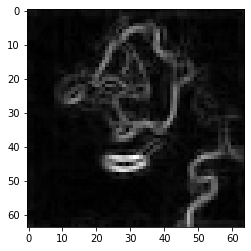

In [ ]:
def grayscale(image):
    grey = np.mean(image, axis = 0)
    return grey
from scipy import ndimage
# image = img_lst[110][0] # single tensor image isolate from batch 
image = img_lst[110][0].detach().cpu().numpy()
image = grayscale(image)
print(image.shape)
#image = grayscale(image)
#image = img_lst[110][0].detach().cpu().numpy()
img_x = ndimage.sobel(image, 0) # sobel operation across horizontal
img_y = ndimage.sobel(image, 1) # sobel operation across vertical
sob = np.hypot(img_x, img_y)
# sob = grayscale(sob)
#sob = np.sum(sob, axis = [-1,-1,-1])
#grad_comp = np.sqrt(img_x + img_y)
#grad_comp = np.sum(grad_comp,axis=-1)
#grad_mag_sqrt = np.sum(grad_comp, axis = -1)
#grad_mag_imge = np.sqrt(grad_mag_sqrt)
#tf.math.reduce_sum(grad_comp,axis=-1)
#image_sobel = np.sqrt((img_x ** 2) + (img_y **2))
# transpose image to obtain correct dimensions
# plot
# plt.imshow(np.transpose(grad_mag_imge,(1,2,0)))
#plt.imshow(np.transpose(grad_comp,(1,2,0)))
plt.imshow(sob, cmap='gray')


torch.Size([3, 64, 64])


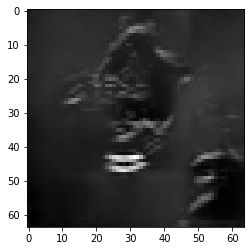

In [ ]:
from scipy import ndimage
image = img_lst[110][0] # single tensor image isolate from batch 
#image = grayscale(image)
print(image.shape)
#image = grayscale(image)
#image = img_lst[110][0].detach().cpu().numpy()
img_x = ndimage.sobel(image, 0) # sobel operation across horizontal
img_y = ndimage.sobel(image, 1) # sobel operation across vertical
sob = np.hypot(img_x, img_y)
sob = grayscale(sob)
# sob = np.sum(sob, axis = [-1,-1,-1])
# grad_comp = np.sqrt(img_x + img_y)
# grad_comp = np.sum(grad_comp,axis=-1)
# grad_mag_sqrt = np.sum(grad_comp, axis = -1)
# grad_mag_imge = np.sqrt(grad_mag_sqrt)
# tf.math.reduce_sum(grad_comp,axis=-1)
# image_sobel = np.sqrt((img_x ** 2) + (img_y **2))
# transpose image to obtain correct dimensions
# plot
# plt.imshow(np.transpose(grad_mag_imge,(1,2,0)))
# plt.imshow(np.transpose(grad_comp,(1,2,0)))
plt.imshow(sob, cmap='gray')

### Save singles of generated images

In [ ]:
# stores a single image
#for j in range(len(img_lst)):
#  for i in range(len(img_lst[j])):
#    torchvision.utils.save_image(img_lst[j][i], '/content/drive/MyDrive/neural_networks/wikiart_gen_imgs/%d%d.JPG' % (j,i), normalize = True)
    #imgs.append((vutils.make_grid(img_lst[j][i].to(device), padding=2, normalize=True).cpu()))
#  if (j % 20 == 0): 
#    print('Stores [%d / %d] image batches' % (j * len(img_lst[0]) , len(img_lst[0])* len(img_lst)))

Stores [0 / 7936] image batches


KeyboardInterrupt: ignored